# Functional analysis of single-cell transcriptomics: part one

# introduce what single cell and transcriptomics are

# Introduce dataset


## Loading packages

First, we need to load the relevant packages, `scanpy` to handle scRNA-seq data and decoupler to use statistical methods.

In [2]:
import scanpy as sc
import scanpy.external as sce
import decoupler as dc

# Only needed for processing and plotting
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
metadata = pd.DataFrame([
    ['control'],
    ['control'],
    ['control'],
    ['covid'],
    ['covid'],
    ['covid']],
    columns=['condition'],
    index=['control_a', 'control_b', 'control_c', 'covid_d', 'covid_e', 'covid_f']
)
metadata

,condition
control_a,control
control_b,control
control_c,control
covid_d,covid
covid_e,covid
covid_f,covid


Read 10x-Genomics-formatted mtx directory obtained from running the aligment tool called CellRanger to obtain an `AnnData` object:

In [ ]:
adata = sc.read_10x_mtx('data/covid_e')
adata

Inside an `AnnData` object we have different attributes, here are the most important ones:
* X: This is where the main assay is stored. At the beginning here are the raw integer gene counts
* obs: Metadata dataframe for cells (rows)
* var: Metadata dataframe for genes (columns)
* layers: Other assays with the same dimensions than X

You can read more about it in the official [documentation](https://anndata.readthedocs.io/en/latest/index.html)

<img src="https://anndata.readthedocs.io/en/latest/_images/anndata_schema.svg"
     width="400" 
     height="500" />

To visualize the cell metadata run:

In [ ]:
adata.obs

For the gene metadata:

In [ ]:
adata.var

And the expression matrix (in sparse format to save memory):

In [ ]:
adata.X

## Quality Control (QC)

Before analysing the single-cell gene expression data, we must ensure that all cellular barcode data correspond to viable cells.

First we need to apply a basic filtering where we remove cells (rows) with few expressed genes and genes (columns) with that are
expressed in few cells.

In [ ]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

We can then compute quality control (QC) metrics:

* `total_counts`: Total number of UMI counts for each cell. Cells with big values might be doublets*
* `pct_counts_mt`: Percentage of expressed genes that are mitocondrial. A high percentage might indicate cell death
* `n_genes_by_counts`: Number of genes that have at least one UMI count. A low value means that the cell is empty

*Doublets (or multiplets) arise in scRNA-seq data when two (or more) cells are mistakenly considered as a single cell, due for instance to being captured and processed in the same droplet on a micro-fluidics device.

In [ ]:
# Compute QC metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

We can easly plot these metrics into scatterplots:

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

There seem to be some cells with higher levels of mitoconrial genes, we should remove them since these cells are not very
informative.

Moreover, it is always good to trim cells with too much number of genes expressed (`n_genes_by_counts`) because
most probably they are doublets.

We can filter our object based on these criteria:

In [ ]:
# Filter cells
adata = adata[(adata.obs.n_genes_by_counts < 5000) & (adata.obs.n_genes_by_counts > 500), :]
adata = adata[adata.obs.pct_counts_mt < 15, :]
adata

With our current relaxed filtering strategy we might still have doublets in our data which might bias downstream analyses. To
remove them, there are many methods that compute doublet scores, one of them being `scrublet`. We can compute doublets scores by:

In [ ]:
# Compute doublets score
sce.pp.scrublet(adata, verbose=True)

`scrublet` computes a score that goes from 0 to 1, 1 being very probable that a cell is a doublet. We can plot the distirbution
of scores in a histogram:

In [ ]:
plt.hist(adata.obs['doublet_score'], bins=40)
plt.ylabel('counts')
plt.xlabel('doublet_score')
plt.show()

To remove outliers we can set a threshold at 0.2:

In [ ]:
# Filter cells
adata = adata[adata.obs['doublet_score'] <= 0.2, :]
adata

## Normalization

Each count in a count matrix represents the successful capture, reverse transcription and sequencing of a molecule of cellular mRNA. Count depths for identical cells can differ due to the variability inherent in each of these steps. Thus, when gene expression is compared between cells based on count data, any difference may have arisen solely due to sampling effects. Normalization addresses this issue by scaling count data to obtain correct relative gene expression abundances between cells.
The most used normalization technique is to normalize each cell by total counts over all genes, so that every cell has the same total count after normalization. Afterwards we multiply the normalized counts to the estimated library size (1e4) and we apply the log(x+1), which mitigates (but does not remove) the mean–variance relationship in single-cell data.

Before normalizing, we will store the raw integer counts into the `layers` attribute of our object

In [ ]:
adata.layers['counts'] = adata.X.copy()

Then we normalize and log transform:

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

We can then store the results into another assay in the layers attribute:

In [ ]:
adata.layers['logcounts'] = adata.X.copy()

## Feature selection

To identify different cell clusters in our data we first need to reduce their dimmensions by running principal component analysis (PCA) to reveal the main axes of variation and denoise the data. However before that we need to make a selection of features (genes) that maximize the differences between our cells. We can compute the Highly Variable Genes (HVG) by running this code:

In [ ]:
sc.pp.highly_variable_genes(adata)

We can see which ones are flagged as HVG in the `var` attribute:

In [ ]:
adata.var

## Dimensionality reduction

Once we have a set of genes that account for the most variability in our data, we can scale our features and apply PCA.

In [ ]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

The obtained PCs are stored in the `obsm` attribute:

In [ ]:
adata.obsm['X_pca']

## Visualization

For visualization purposes, it is standard practice to use non-linear dimensionality reduction methods, for example Uniform Approximation and Projection method (UMAP).

To run UMAP, first we need to compute a neighbouring graph between cells from the PCs space and them run the algorithm:

In [ ]:
# Compute neighbours and UMAP embedding
sc.pp.neighbors(adata)
sc.tl.umap(adata)

We can then find clusters in the neighbour graph which hopefully will belong to different cell types. To find clusters there
are different algorithms available, here we will use the leiden algorithm:

In [ ]:
# Find clusters in the NN graph
sc.tl.leiden(adata)

We can visualize the obtained clusters in the UMAP embedding. We can also plot the expression of genes into the UMAP,
for example CD40, a known marker gene for B cells:

In [ ]:
# Visualize UMAP
sc.pl.umap(adata, color=['leiden','CD40'])

## Annotation

Identifying and annotating clusters relies on using external sources of information describing the expected expression profiles of individual cell identities. To do so, we need to identify first marker gene sets by applying differential expression (DE) testing between two groups: the cells in one cluster and all other cells in the dataset.

As marker genes are expected to have strong differential expression effects, simple statistical tests such as the t-test are often used to rank genes by their difference in expression between these two groups. The top-ranked genes from the respective test statistic are regarded as marker genes. Then, clusters can be annotated by comparing marker genes from the dataset and marker genes from prior knowledge.

To compute marker genes run:

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test', layer='logcounts')

We can extract the results as a dataframe with the following function:

In [ ]:
df = sc.get.rank_genes_groups_df(adata, group=None)
df

We can then visualize the top 3 identified marker genes per cluster using a dotplot:

In [ ]:
markers = df.groupby('group').head(3)['names'].values
sc.pl.dotplot(adata, var_names=markers, groupby='leiden', dendrogram=True, standard_scale='var')

Some clusters show well known marker genes for immune cell types. If we take a closer look we can manually annotate the obtained
clusters. Note that it is possible that some clusters might be annotated as the same cell type if their marker genes overlap.

In [ ]:
annotation_dict = {
 '0': 'T cells',
 '1': 'Neutrophils',
 '2': 'Neutrophils',
 '3': 'T cells',
 '4': 'B cells',
 '5': 'T cells',
 '6': 'Platelets',
 '7': 'Monocytes',
 '8': 'T cells',
 '9': 'Monocytes',
 '10': 'Dendritic cells',
 '11': 'Erythroid-like and erythroid precursor cells',
}

Then, we can add a metadata column with the annotated cell types and visualize the results:

In [ ]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type')

## Integration

Up until one we were working with just one of the samples in our dataset. To be able to make comparisons between healthy and
disease patients we need to process the other samples and merge them together.

We will read the different samples, apply the previously explained QC steps and normalization, and merge all cells into one single
object. To achieve this, we will define some functions that perform the mentioned steps:

In [ ]:
def qc_sample(sample_id):
    """
    Reads and performs QC on a given sample.
    """

    # Read
    adata = sc.read_10x_mtx(os.path.join('data', sample_id))

    # Basic filtering
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)

    # Compute QC metrics
    adata.var['mt'] = adata.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

    # Filter cells
    adata = adata[(adata.obs.n_genes_by_counts < 5000) & (adata.obs.n_genes_by_counts > 500), :]
    adata = adata[adata.obs.pct_counts_mt < 15, :]

    # Compute doublets score
    sce.pp.scrublet(adata, verbose=False)

    # Filter cells
    adata = adata[adata.obs['doublet_score'].values <= 0.2, :]

    return adata

def norm_sample(adata):
    """
    Normalizes, transforms and stores counts.
    """

    # Store raw counts
    adata.layers['counts'] = adata.X.copy()

    # Normalize and log transform
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # Store logcounts
    adata.layers['logcounts'] = adata.X.copy()

    return adata

In [ ]:
# Init empty adata
adata = []

# Iterate samples
for sample_id in metadata.index:

    print(sample_id)

    # QC and normalize sample
    s_adata = qc_sample(sample_id)
    s_adata = norm_sample(s_adata)

    # Add metadata
    s_adata.obs['sample_id'] = sample_id
    s_adata.obs['condition'] = metadata.loc[sample_id, 'condition']
    
    # Add to rest
    adata.append(s_adata)

# Merge adatas into one
adata = adata[0].concatenate(adata[1:], join="outer")

We can notice that now in the `obs` we see we have different samples and conditions:

In [ ]:
adata.obs

Like before, we need to find HVG. In this case, we will compute them per sample and then select the top 3000 genes that are HVG
across as many samples as possible:

In [ ]:
# Compute HVG
sc.pp.highly_variable_genes(adata, batch_key='batch', layer='logcounts')

# Filter by HVG
num_hvg_genes = 3000
batch_msk = np.array(adata.var['highly_variable_nbatches'] > 1)
hvg = adata.var[batch_msk].sort_values('highly_variable_nbatches').tail(num_hvg_genes).index
adata.var['highly_variable'] = [g in hvg for g in adata.var.index]

Once we find HVG that are representative in all samples, we can scale and compute PCA on them.

In [ ]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

# Remove scaled counts and put back logcounts
adata.X = adata.layers['logcounts'].copy()

The next step would be to perform UMAP but we need to consider batch effects.
Batch effects can occur when cells are handled in distinct groups. These groups can consist of cells on different chips, cells in different sequencing lanes or cells harvested at different time points. The differing environments experienced by the cells can have an effect on the measurement of the transcriptome or on the transcriptome itself.

To correct for these effects we need to integrate the samples by correcting by technical effects. Different methods of integration
exists, all of them work on correcting the cell embeddings (not directly on the gene expression) to regress this unwanted variability.
As an example we will use `harmony` which modifies the PCs into comparable features across batches:

In [ ]:
sce.pp.harmony_integrate(adata, 'batch', max_iter_harmony=30)

Once we have the corrected PCs, we can compute NN and the UMAP embedding:

In [ ]:
# Compute neighbours and UMAP embedding
sc.pp.neighbors(adata)
sc.tl.umap(adata)

We can also find clusters:

In [ ]:
# Find clusters in the NN graph
sc.tl.leiden(adata)

Here we visualize the obtained clusters, the original sample ids and their condition:

In [ ]:
# Visualize UMAP
sc.pl.umap(adata, color=['leiden', 'sample_id', 'condition'], wspace=0.3)

We can observe that almost all defined clusters seem to come from multiple samples, meaning that the integration worked.

## Automatic cell type annotation

Before we showed that if we look at the marker genes of a given cluster, we could manually annotate the cell clusters with known
marker genes. This process if done manually over dozens of clusters can become tedious but it can become automated with the use
of gene sets.

Gene sets are groups of genes that can be associated to a biological term such as pathways, diseases or in this case cell types.

Thanks to recent and ongoing efforts such as the mouse brain atlas (Zeisel et al, 2018) or the Human Cell Atlas (Regev et al, 2017), reference databases are increasingly becoming available. One of them is PanglaoDB, a database of markers for human and mouse.

We can access PanglaoDB trough OmniPath, a meta-resource of databases, and filter it by canonical human genes:

In [ ]:
# Retrieve database
panglaodb = dc.get_resource('PanglaoDB')

# Filter by canonical_marker and human
panglaodb = panglaodb[(panglaodb['human']=='True') & (panglaodb['canonical_marker']=='True')]

# Remove duplicated entries
panglaodb = panglaodb[~panglaodb.duplicated(['cell_type', 'genesymbol'])]
panglaodb

We can then use the framework `decoupler` to perform Over Representation Analysis and enrich each cell for cell type annotations:

In [ ]:
dc.run_ora(mat=adata, net=panglaodb, source='cell_type', target='genesymbol', min_n=3, verbose=True, use_raw=False)

We can then extract the enrichment scores into a new object:

In [ ]:
acts = dc.get_acts(adata, 'ora_estimate')

Let us visualize some of the enrichments:

In [ ]:
# Visualize UMAP
sc.pl.umap(acts, color=['leiden', 'B cells', 'T cells', 'Platelets'], wspace=0.3)

We can also extract the mean enrichment per cluster and visualize it as a clustermap:

In [ ]:
mean_enr = dc.summarize_acts(acts, groupby='leiden', min_std=1)
sns.clustermap(mean_enr, xticklabels=mean_enr.columns, cmap='coolwarm', standard_scale=0)
plt.show()

We can manually annotate the clusters based on the enrichment, or we can use a function from `decoupler` that selects the
most enriched annotation per cluster:

In [ ]:
# Automatically select top predicted cell type per cluster
annotation_dict = dc.assign_groups(mean_enr)
annotation_dict

With the new annotation we can update the cell metadata and visualize

In [ ]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type')

## Differential Expression Analysis (DEA)

Now that we have our atlas annotated, we can start looking at differences between our disease and healthy samples.
To do so, we will apply statistics to identify which genes are changing the most. To minimise sampling effects, we will perform
the test at the pseudobulk level, which is the colapsing of molecular readouts coming from one sample in a given cell type into
one single profile.

To compute pseudobulk profiles we can use `decoupler`:

In [10]:
# Get pseudo-bulk profile
padata = dc.get_pseudobulk(adata, sample_col='sample_id', groups_col='cell_type', layer='counts', min_prop=0.2, min_smpls=3)

# Normalize
sc.pp.normalize_total(padata, target_sum=1e4)
sc.pp.log1p(padata)
padata

/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/decoupler/utils_anndata.py:268: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)
/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 32 × 7365
    obs: 'sample_id', 'condition', 'batch', 'cell_type'
    uns: 'log1p'

Once we have generated robust pseudo-bulk profiles for each sample and cell type, we can run any statistical test to compute DEA. For this example we will use t-test as is implemented in scanpy but we could use any other.

In [11]:
logFCs, pvals = dc.get_contrast(padata,
                                group_col='cell_type',
                                condition_col='condition',
                                condition='covid',
                                reference='control',
                                method='t-test'
                               )
logFCs

,A1BG,AAGAB,AAK1,AAMP,AAR2,AARS1,AARS2,AATF,AATF-1,ABCB1,...,ZRANB2,ZRSR2,ZSCAN2,ZSWIM6,ZSWIM7,ZSWIM8,ZXDC,ZYG11B,ZYX,ZZEF1
B cells naive,-0.695756,0.00000,-1.181385,0.000000,0.000000,0.636842,-0.194534,-0.111884,0.000000,0.000000,...,-0.089550,0.006110,0.000000,0.000000,0.000000,0.000000,0.000000,0.965155,0.000000,0.228279
Dendritic cells,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Monocytes,-0.150854,-0.30146,0.290070,0.330853,1.255615,0.634714,0.537959,-0.583964,0.024772,0.000000,...,0.266832,0.146210,0.254742,0.111009,0.051165,0.404000,0.153299,0.512849,0.451267,0.145024
NK cells,0.000000,0.00000,-0.040727,0.000000,0.000000,0.000000,0.000000,0.047430,0.000000,-0.150639,...,0.294128,-0.343749,0.000000,0.000000,0.000000,0.195674,0.000000,0.156584,0.000000,-0.121702
Neutrophils,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014061
T cells,-0.360406,0.00000,-0.216832,0.000000,0.000000,0.479775,0.000000,-0.157460,-0.113927,0.000000,...,-0.002940,0.061071,0.000000,0.000000,0.054785,0.000000,0.000000,0.312430,0.483740,0.126552


We can transform these results into a dataframe and store them for future use:

In [12]:
deg = dc.format_contrast_results(logFCs, pvals)
deg.to_csv('deg.csv', index=False)
deg

,contrast,name,logFCs,pvals,adj_pvals
0,B cells naive,RBM34,1.174709,0.000041,0.303025
1,B cells naive,HLA-DPB1-4,7.916212,0.000387,1.0
2,B cells naive,KDM5C,-1.128315,0.000988,1.0
3,B cells naive,HLA-F-2,-0.692687,0.003163,1.0
4,B cells naive,CD37,-0.339621,0.003946,1.0
...,...,...,...,...,...
44185,T cells,CCDC198,0.000000,1.000000,1.0
44186,T cells,PLAA,0.000000,1.000000,1.0
44187,T cells,CCDC32,0.000000,1.000000,1.0
44188,T cells,FIG4,0.000000,1.000000,1.0


We can also visualize the results as a volcano plot:

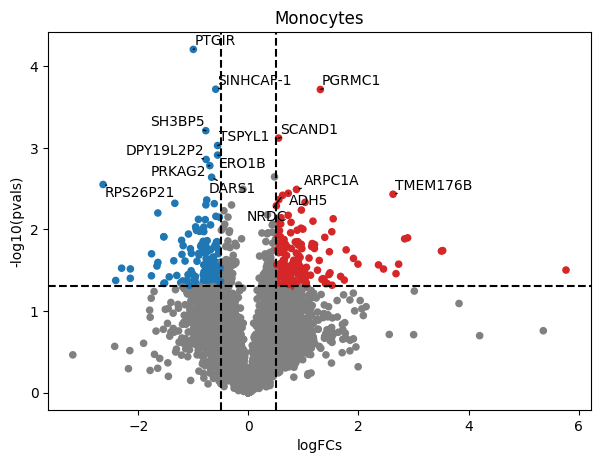

In [13]:
dc.plot_volcano(logFCs, pvals, 'Monocytes', top=15, sign_thr=0.05, lFCs_thr=0.5)

Remove duplicated gene that causes issues when converting to Seurat

In [14]:
adata = sc.read_h5ad("data/adata.h5ad")

In [15]:
# adata = adata[:,~np.isin(adata.var.index, ["C4B-2", "C4B_2"])]

In [16]:
# adata.write_h5ad("data/adata.h5ad")

### Functional enrichment of biological terms

While some of these genes might be informative, it is rather hard to make a biological interpretation of what is going on.

As such, a simple way to reduce the dimensionality of our data and improve its interpretability is to aggregate it using biologically-meaningful functional terms.

A well-known example of such as collection is the `MSigDB` resource, and we will use `ORA` via decoupler as before.

In [17]:
# We Retrieve MSigDB resource via OmniPath
msigdb = dc.get_resource('MSigDB')

Then we only keep a desired geneset collection from MSigDB.
For example the Hallmark gene sets are a very commonly-used option with specific and well-defined biological sates and processes.

MSigDB Hallmakrs represent a type of manually-curated ensemble of gene sets, based on the overlaps of the remainder of MSigDB collections.
Hence, they likely represent the least biologically-redudant gene sets in MSigDB.

In [18]:
# Format MSigDB
msigdb = msigdb[msigdb['collection']=='hallmark']
msigdb.geneset = [x[9:] for x in msigdb.geneset] # remove 'HALLMARK' from name
msigdb = msigdb.drop_duplicates(['geneset', 'genesymbol'])
msigdb['weight']=1 # placeholder - we will comeback to this

Perhaps, ORA is perhaps the simplest way to obtain biological term enrichments.
Thus, we will first make use of the DEGs together with MSigDB to perform ORA /w decoupler.

In this case, we ask simply the question : 
"Are there any biologically-meaningful terms that are overrepresented among the most changed genes within each cluster?".

As such, we first need to obtain the significant hits per cluster

In [19]:
top_genes = dc.format_contrast_results(logFCs, pvals)

In [20]:
top_genes = top_genes[(np.abs(top_genes['logFCs']) > 0.5) & (top_genes['pvals'] < 0.05)]

In [23]:
# Get ORA p-values
enr_pvals = dc.get_ora_df(top_genes, msigdb,
                          groupby='contrast', features='name',
                          source='geneset', target='genesymbol')
enr_pvals

,ADIPOGENESIS,ALLOGRAFT_REJECTION,ANDROGEN_RESPONSE,APICAL_JUNCTION,APOPTOSIS,CHOLESTEROL_HOMEOSTASIS,COAGULATION,COMPLEMENT,DNA_REPAIR,E2F_TARGETS,...,OXIDATIVE_PHOSPHORYLATION,P53_PATHWAY,PEROXISOME,PROTEIN_SECRETION,REACTIVE_OXYGEN_SPECIES_PATHWAY,TNFA_SIGNALING_VIA_NFKB,UNFOLDED_PROTEIN_RESPONSE,UV_RESPONSE_DN,UV_RESPONSE_UP,XENOBIOTIC_METABOLISM
B cells naive,9.560797e-02,5.547668e-06,0.035246,1.000000,6.255212e-02,0.001041,0.055798,6.435046e-03,5.089518e-07,7.141638e-08,...,1.474607e-02,4.366647e-03,1.000000,0.055798,0.042146,1.522181e-01,0.000075,1.000000,0.102079,1.000000e+00
Dendritic cells,4.389395e-02,5.305008e-02,0.015900,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,...,1.351901e-06,4.389395e-02,1.000000,1.000000,1.000000,2.442166e-03,0.037742,1.000000,0.001030,1.000000e+00
Monocytes,8.573011e-07,7.227872e-05,0.066892,0.000086,5.709143e-08,0.003780,0.000002,3.404054e-13,6.881257e-06,5.587472e-05,...,4.529114e-08,8.365609e-04,0.001833,0.004994,0.002724,1.748625e-08,0.000016,0.000086,0.000001,3.028317e-12
NK cells,1.683496e-07,9.863908e-09,0.048534,0.001982,8.566841e-02,0.001982,0.002625,5.079210e-07,1.867939e-06,3.614337e-07,...,1.174500e-04,2.453462e-09,0.048534,0.000052,0.057956,7.361906e-15,0.112569,0.001982,0.000012,8.566841e-02
Neutrophils,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000,1.000000,0.004193,4.795805e-07,0.008370,1.000000,0.000048,1.000000e+00
T cells,6.536602e-03,9.601501e-03,0.043237,0.000023,2.661745e-03,0.001571,0.068281,1.395696e-01,1.000000e+00,3.448253e-04,...,7.078006e-13,2.270598e-04,0.000757,0.002082,0.001129,1.725631e-02,0.000139,0.001571,0.000282,5.412636e-05


In [24]:
# Set 0s to min p-value & log-transform
enr_pvals.values[enr_pvals.values == 0] = np.min(enr_pvals.values[enr_pvals.values != 0])
enr_pvals = -np.log10(enr_pvals)

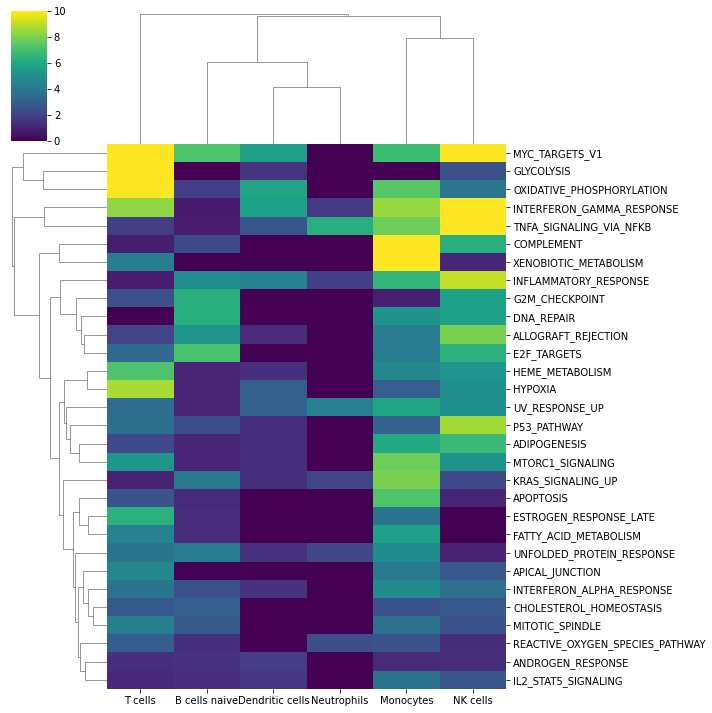

In [25]:
# Get top 10 most over-represented gene sets
top = 10
top_idxs = set()
for row in enr_pvals.values:
    sort_idxs = np.argsort(-np.abs(row))
    top_idxs.update(sort_idxs[:top])
top_idxs = np.array(list(top_idxs))
top_names = enr_pvals.columns[top_idxs]
names = enr_pvals.index.values
top = pd.DataFrame(enr_pvals.values[:, top_idxs], columns=top_names, index=names)

# Plot
sns.clustermap(top.T, cmap='viridis', vmax=10)
plt.show()

### Enrichment Analysis

In [26]:
def plot_topheat(acts, top=10, **kwargs):
    # Set nans to zero to be able to plot
    acts.fillna(0, inplace=True)

    # Get top 10 most active/inactive sources
    top_idxs = set()
    for row in acts.values:
        sort_idxs = np.argsort(-np.abs(row))
        top_idxs.update(sort_idxs[:top])
    top_idxs = np.array(list(top_idxs))
    top_names = acts.columns[top_idxs]
    names = acts.index.values
    top = pd.DataFrame(acts.values[:,top_idxs], columns=top_names, index=names)

    # Plot
    sns.clustermap(top.T, center=0, cmap='coolwarm', **kwargs)
    plt.show()

As a way to distance ourselves away from using arbitrary thresholds for the genes of interest, 
such as the ones defined above for p-value and logFC,
we could alternatively run `GSEA` (Gene Set Enrichment Analysis). 

GSEA's main advantages over ORA is that it considers all genes in the dataset, and takes both extremes into account - i.e. both genes with high and low ranking simultaneously.

In [27]:
# Infer pathway activities with mlm
msigdb_scores, msigdb_nscores, msigdb_pvals  = dc.run_gsea(mat=logFCs,
                                                           source='geneset',
                                                           target='genesymbol',
                                                           net=msigdb,
                                                           verbose=True)

  0%|          | 0/1 [00:00<?, ?it/s]

Running gsea on mat with 6 samples and 7365 targets for 50 sources.


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


In this case, we can observe the over- and downregulated genesets between the conditions simultaneously. 

In particular, we use the normalized enrichment scores from GSEA, which represents both the sign and the statistical deviation of change.

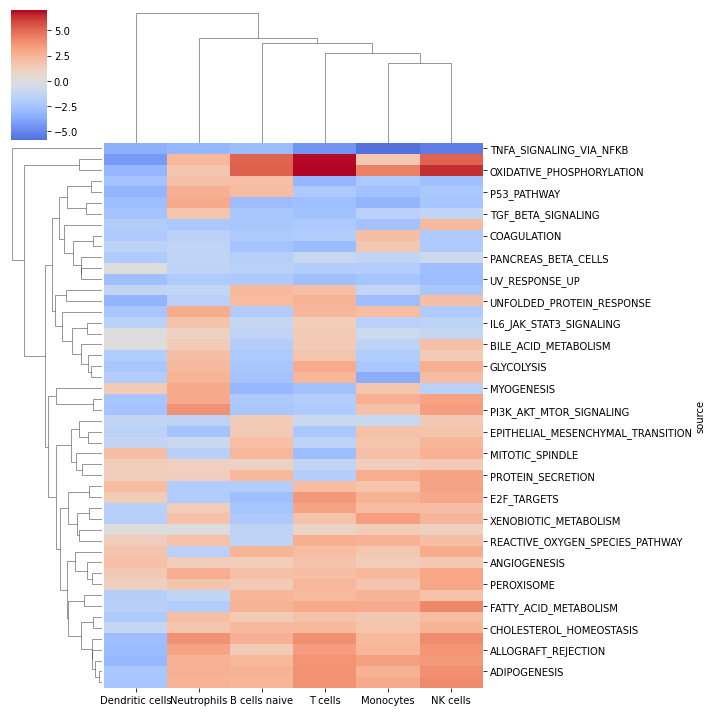

In [28]:
# Set nans to zero to be able to plot
msigdb_nscores.fillna(0, inplace=True)

sns.clustermap(msigdb_nscores.T, center=0, cmap='coolwarm')
plt.show()

## Transcription factor and cytokine activity estimation from prior-knowledge footprints

As a next step, we will introduce a percieved improvement in both the resource and methodology.

Namely, classical GEO terms or gene sets focus on genes typically thought to be part of the same process.
Instead, one could use genes which change in response to a given entity, to estimate the 'activity' of that entity. 
We term such a collection of genes a `footprint`.

Perhaps, the most classical example of footprints using the expression of genes, which are part of the regulon of a transcription factor (TF).

Here, we will use a collection of manually-curated TFs, called [DoRothEA]().

Something specific about DoRothEA is that it comes with weights for each TF target, which represent both the quality of annotation, but also the sign of interaction.
In other words, we are no longer asume that all genes in a gene set are equally-imporant, and we also take into account whether a gene can be negatively associated with a given gene set (or in our case TF).

In this case, we will use the very simple weighted mean (`wmean`) method to take both the magnitude of change (logFC) and the sign of the TF-target interactions into account.

In [29]:
# Retrieve DoRothEA gene regulatory network
dorothea = dc.get_dorothea()

In [30]:
tf_acts, tf_pvals = dc.dense_run(dc.run_wmean, mat=logFCs, net=dorothea, verbose=True)
tf_acts

  0%|          | 0/6 [00:00<?, ?it/s]

Dense run of wmean on mat with 6 samples and 7365 potential targets.


100%|██████████| 6/6 [00:14<00:00,  2.46s/it]


,AHR,AR,ARID2,ARID3A,ARNT,ARNTL,ASCL1,ATF1,ATF2,ATF3,...,MBD2,NR1H3,REL,SATB1,SIX5,STAT4,XBP1,ZNF24,ZNF584,GLI2
B cells naive,0.048451,-0.220316,0.022527,-0.193122,-0.141473,-0.070239,-0.006619,-0.000919,-0.289555,0.180772,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dendritic cells,NaN,-0.110520,NaN,NaN,NaN,NaN,NaN,-0.589753,-0.210900,0.340078,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Monocytes,0.194535,0.020045,-0.018355,-0.029965,0.012350,-0.508835,0.050598,-0.050834,-0.187321,-0.142997,...,0.394623,-0.631346,-0.647641,0.136645,-0.154337,-0.072380,0.154863,-0.169072,0.308863,NaN
NK cells,-0.117392,0.026009,0.086709,0.375800,0.064382,-0.184523,0.017556,0.014139,-0.338242,-0.049187,...,NaN,NaN,-0.951199,-0.049095,NaN,-0.114676,NaN,NaN,NaN,NaN
Neutrophils,-0.028399,0.425490,-0.503968,NaN,-0.111515,NaN,NaN,0.052548,-0.426150,0.229508,...,NaN,NaN,-0.357195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T cells,0.004382,0.024664,-0.190887,0.084539,0.035942,-0.560573,-0.140504,-0.096926,-0.352537,-0.150893,...,NaN,NaN,NaN,-0.252507,NaN,0.119322,0.104840,NaN,NaN,-0.061723


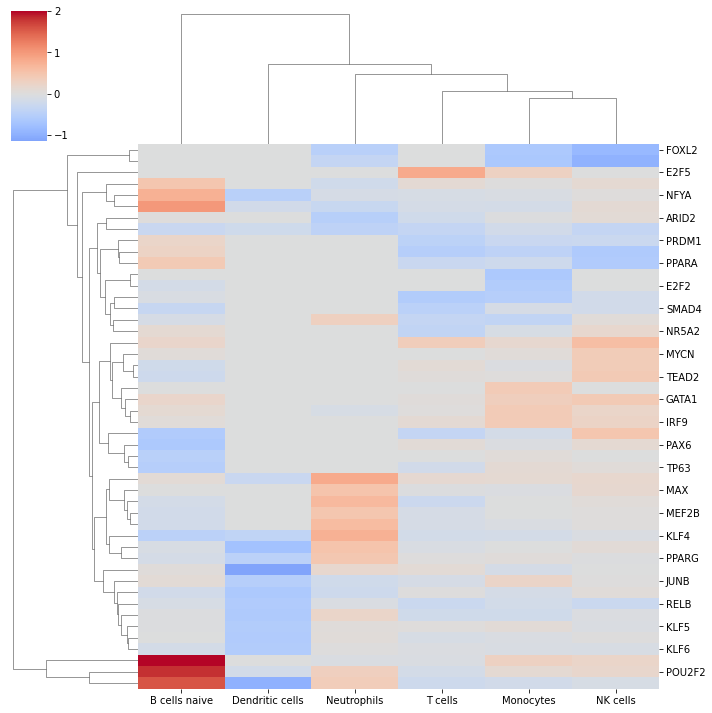

In [31]:
plot_topheat(tf_acts, vmax=2)

Hmmm, perhaps it looks a bit underwhelming?
Does this mean that there is no change in TF activity or do you think that perhaps we should use a more complited method?

Let's come back to this! :)

### Cytokine activity inference

To estimate pathway activities we will use [CytoSig's resource](https://www.nature.com/articles/s41592-021-01274-5), a data-driven compedium of high-quality Cytokine Signatures. 

Cytokines often exhibit pleiotropic interactions that depend heavily on cell-type-specificity, but also the activity of other biological components, including other cytokines.
To this end, one could also consider attempting to address for these complicated relationships between cytokines.

Perhaps, the simplest way to achieve this is to fit a multi-variate model (mlm), which inherintly take co-linearity into account.

In a recent benchmark, we saw that `mlm` yielded the best performance when using transcription factor pertrubation experiments.

In [32]:
# Read CytoSig signatures
# Keep top 500 genes
cytosig = pd.read_csv("data/cytosig_signatures.csv")
# Keep highest 500 weights per gene set
cytosig = cytosig.sort_values(by='weight', key=abs, ascending=False).groupby('source').head(500).sort_values(['source', 'weight']).reset_index()

In [33]:
# Infer pathway activities with mlm
cyto_acts, pathway_pvals = dc.dense_run(dc.run_mlm, mat=logFCs, net=cytosig, verbose=True)
cyto_acts

  0%|          | 0/6 [00:00<?, ?it/s]

Dense run of mlm on mat with 6 samples and 7365 potential targets.


100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


,Activin_A,BDNF,BMP2,BMP4,BMP6,CD40L,CXCL12,EGF,FGF2,GCSF,...,MCSF,NO,OSM,TGFB1,TGFB3,TNFA,TRAIL,TWEAK,VEGFA,WNT3A
B cells naive,0.103343,0.088344,-0.487874,-0.167773,0.927034,-0.211387,-0.571410,0.052457,-0.420823,-0.033087,...,0.216400,0.592170,0.253867,-0.876986,-0.747698,0.602610,-0.599335,0.008456,-0.227078,-0.440776
Dendritic cells,-0.392105,0.195357,1.358259,0.116114,1.374251,0.250910,-0.179062,0.541323,-0.546982,-0.605623,...,0.117682,0.364183,0.379369,-0.854595,-0.425177,-0.763425,-0.673597,1.162662,-1.491487,0.425105
Monocytes,-1.177800,1.713925,0.438258,-0.891486,0.390743,-0.340372,0.228965,-1.182189,-1.589064,-0.058647,...,1.320744,-0.655802,0.680301,-0.911689,-1.095117,-1.171445,-1.951192,0.544634,-3.480886,1.704982
NK cells,0.072449,-1.127240,-0.787223,0.088773,1.527272,-1.668475,-2.058769,-1.716733,1.609551,0.472793,...,0.219221,-0.784263,-0.271689,-1.032895,-3.026203,0.143239,-2.096663,-1.479159,-1.247483,0.355224
Neutrophils,1.056036,-0.910409,0.050724,-0.194506,0.021242,-1.333803,0.200197,1.625729,1.545410,0.734852,...,1.816210,0.143547,-1.532503,-0.308935,-0.633609,2.221681,0.846012,-0.101302,-2.383634,0.563390
T cells,0.899331,-0.003114,-1.685433,-0.855828,-0.193560,-3.179074,-0.712767,-3.538424,-0.167843,-1.335592,...,0.279498,-1.564574,2.670645,-0.598138,-4.136490,0.445995,-2.100523,0.241948,-2.418213,0.749680


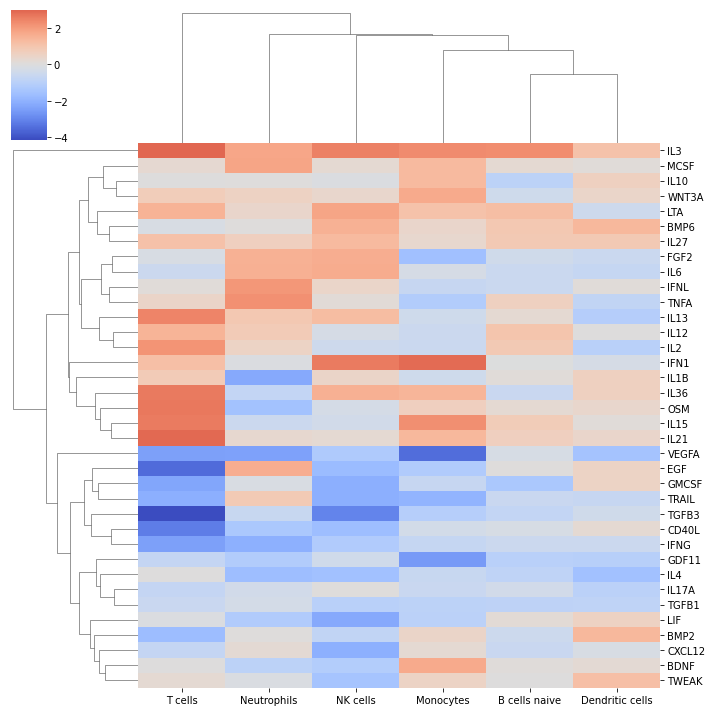

In [34]:
# Plot enrichment (here we plot the t-values of the coefficients)
plot_topheat(cyto_acts, vmax=3)

D) We see multiple down- and up-regulated Cytokines across the cell types, can we tie those to the results above?

Q) Do you think that a simple linear model can capture the vast biological complexity?

Finally, let's come back to the underwhelming TF results that we saw earlier.

Perhaps, we could make use of the multitude of methods in decoupleR to obtain better results!

In [35]:
tf_acts, tf_pvals = dc.dense_run(dc.run_consensus, mat=logFCs, net=dorothea, verbose=True)
tf_acts

  0%|          | 0/6 [00:00<?, ?it/s]

Dense run of consensus on mat with 6 samples and 7365 potential targets.


100%|██████████| 6/6 [00:15<00:00,  2.65s/it]


,AHR,AR,ARID2,ARID3A,ARNT,ARNTL,ASCL1,ATF1,ATF2,ATF3,...,MBD2,NR1H3,REL,SATB1,SIX5,STAT4,XBP1,ZNF24,ZNF584,GLI2
B cells naive,0.031474,-1.874693,0.085992,-0.512972,-0.304073,-0.265417,0.089739,-0.080568,-1.187490,0.321444,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dendritic cells,NaN,0.575204,NaN,NaN,NaN,NaN,NaN,-0.536555,-0.066068,1.831086,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Monocytes,1.053624,-0.208005,-0.253507,-0.138919,0.275354,-1.487671,0.005168,-0.902947,-1.665724,-0.833085,...,1.48671,-1.405365,-2.109751,0.368820,-0.777215,-0.357929,0.360476,-0.745535,0.931408,NaN
NK cells,-0.607836,-0.280057,0.221970,1.965002,0.107957,-0.975919,-0.359244,-0.598909,-2.545620,-0.470132,...,NaN,NaN,-2.684497,-0.479819,NaN,-0.244796,NaN,NaN,NaN,NaN
Neutrophils,-0.236007,1.558825,-1.686924,NaN,-0.595450,NaN,NaN,0.057053,-1.397265,0.796708,...,NaN,NaN,-1.150439,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T cells,-0.169019,0.632486,-1.408432,0.869183,0.715140,-1.560566,-0.588542,-0.877983,-2.675884,-0.294725,...,NaN,NaN,NaN,-0.798029,NaN,0.160358,0.701955,NaN,NaN,-0.3972


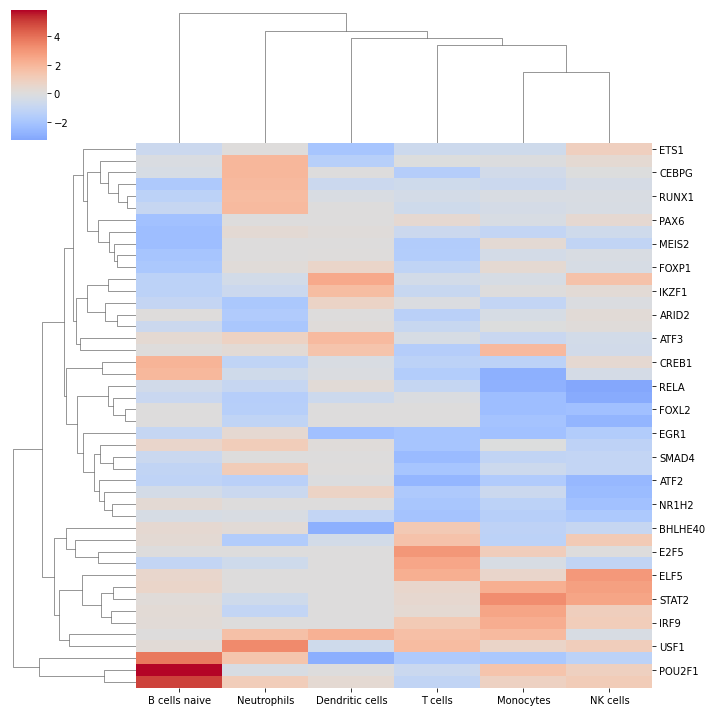

In [36]:
plot_topheat(tf_acts)

This looks much more consistent with what we saw with Cytokine activities and MSigDB!

D) The signal now is much clearer and this is great! Right? :)

However, one could also ask themselves:
"Is it fair to pick the method that fits best your assumptions? Is this not biased?"

What do you think?